# IML assignment 2
### Import libraries and data:

In [179]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LassoCV
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif, chi2, VarianceThreshold
from sklearn.neighbors import LocalOutlierFactor
from sklearn import linear_model

def read_from_file(file):
    df = pd.read_csv(file, header = 0)
    return df._get_numeric_data().values

train_features_file = "train_features.csv"
train_labels_file = "train_labels.csv"
output_file = "submission.txt"

train_features = read_from_file(train_features_file)
labels = read_from_file(train_labels_file)

m = 12  # m = #hours per patient

# Reduce data size for faster testing: (remove this for entire data set)
k = 1000
train_features = train_features[:k*12, :]
labels = labels[:k, :]

n = labels.shape[0] # n = #patients

X_2d = train_features.reshape(n, m, -1)[:, :, 2:]  # features represented as 3D n * m * d_x array
d_x = X_2d.shape[2]  # d_x = #features per patient per hour

X = X_2d[:, :, 1:].reshape(n, m * (d_x - 1))  # features represented as 2D n * m d_x array
X = np.concatenate((X_2d[:, 0, 0].reshape(n, 1), X), axis=1)  # Add age feature seperately so that it is not repeated 12 times
Y = labels[:, 1:]
d_y = Y.shape[1]


### Data impution:

In [180]:
# Data impution:
#imputer = KNNImputer(n_neighbors=10, weights="uniform")  # can also do weights="distance"
#imputer = IterativeImputer(max_iter=2, random_state=0)
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # this is a stupid strategy but KNN is too slow?
X_imp = imputer.fit_transform(X)
print(np.shape(X_imp))
# This gives ok results

(1000, 406)


### Outlier removal:

In [238]:
#clf = EllipticEnvelope(contamination=0.05, random_state=0)
#clf = IsolationForest(random_state=0, n_estimators=100)
#clf.fit(X_imp)
#print("fit done")
#scores_pred = clf.decision_function(X_imp)
#y_pred = clf.predict(X_imp)
#print("predict done")

clf = LocalOutlierFactor(n_neighbors=30, contamination=0.06)
y_pred = clf.fit_predict(X_imp)
X_inliers = X_imp[y_pred==1]
Y_inliers = Y[y_pred==1]
print(X_inliers.shape)

(940, 406)


### Feature selection:

In [239]:
selector = VarianceThreshold(threshold=1e-5)
X_fs = selector.fit_transform(X_inliers)  # remove constant or low variance features
print(X_fs.shape)

# Could also try PCA to reduce feature space dimension?

(940, 403)


### Standardization:

In [240]:
scaler = preprocessing.StandardScaler().fit(X_fs)
#scaler = preprocessing.MinMaxScaler().fit(X_fs)
#scaler = preprocessing.RobustScaler().fit(X_fs)
X_std = scaler.transform(X_fs)
# This also has a negative effect??

In [241]:
# Feature engineering????

### Load test file:

In [242]:
test_features_file = "test_features.csv"
test_features = read_from_file(test_features_file)
X_test_ID = test_features[1:,0]
X_test_ID = pd.unique(X_test_ID)
n_test = test_features.shape[0] // m
X_2d_test = test_features.reshape(n_test, m, -1)[:, :, 2:]
X_test = X_2d_test[:, :, 1:].reshape(n_test, m * (d_x - 1))
X_test = np.concatenate((X_2d_test[:, 0, 0].reshape(n_test, 1), X_test), axis=1)

### Impute and standardize test data:

In [243]:
X_test_imp = imputer.transform(X_test)
X_test_fs = selector.transform(X_test_imp)
X_test_std = scaler.transform(X_test_fs)



### Subtask 1:
Predict whether medical tests are ordered by a clinician in the remainder of the hospital stay: 0 means that there will be no further tests of this kind ordered, 1 means that at least one of a test of that kind will be ordered. In the submission file, you are asked to submit predictions in the interval [0, 1], i.e., the predictions are not restricted to binary. 0.0 indicates you are certain this test will not be ordered, 1.0 indicates you are sure it will be ordered. The corresponding columns containing the binary groundtruth in train_labels.csv are: LABEL_BaseExcess, LABEL_Fibrinogen, LABEL_AST, LABEL_Alkalinephos, LABEL_Bilirubin_total, LABEL_Lactate, LABEL_TroponinI, LABEL_SaO2, LABEL_Bilirubin_direct, LABEL_EtCO2.


In [258]:
# Issue: some patients do not start at hour 1, but 2, 3, 4 etc???
C = 0.15  # Regularization parameter (inversely proportional, not lambda)
clf = svm.SVC(C=C, kernel='rbf', gamma='scale', probability=False, class_weight='balanced')  # The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
#clf = RandomForestClassifier(n_estimators = 200, random_state=0, class_weight='balanced')

# TODO: try prob=True

In [259]:
# CV ROCAUC evaluation:
rocauc = metrics.make_scorer(metrics.roc_auc_score)
ROCAUCs = np.zeros(11)
for i in range(0, 11):
    X_kb = SelectKBest(f_classif, k=70).fit_transform(X_std, Y_inliers[:, i])
    scores = cross_val_score(clf, X_kb, Y_inliers[:, i], cv=5, scoring=rocauc)
    #print("ROCAUCs:", scores)
    print("Label", i, "mean ROCAUC:", scores.mean())
    ROCAUCs[i] = scores.mean()
print("Mean ROCAUC:", ROCAUCs.mean())

Label 0 mean ROCAUC: 0.5163120567375886
Label 1 mean ROCAUC: 0.5356043956043957
Label 2 mean ROCAUC: 0.5
Label 3 mean ROCAUC: 0.5
Label 4 mean ROCAUC: 0.5
Label 5 mean ROCAUC: 0.49976771196283387
Label 6 mean ROCAUC: 0.5
Label 7 mean ROCAUC: 0.5
Label 8 mean ROCAUC: 0.5
Label 9 mean ROCAUC: 0.7898193760262726
Label 10 mean ROCAUC: 0.5
Mean ROCAUC: 0.5310457763937356


In [99]:
# Train, predict, print score:
solution = 0.5*np.ones(np.shape(X_test_std[:,0:11]))

for i in range(0, 11):
    selector_kbest = SelectKBest(f_classif, k=70) 
    X_kb = selector_kbest.fit_transform(X_std, Y_inliers[:, i])
    clf.fit(X_kb, Y_inliers[:, i])

    X_test_std_kb = selector_kbest.transform(X_test_std)
    sol = clf.decision_function(X_test_std_kb)
    solution[:,i] = (1 + np.exp(-sol))**-1
print(solution)

[[0.80732519 0.69754105 0.72354225 ... 0.61268157 0.2673728  0.5589289 ]
 [0.28532546 0.26767515 0.57139671 ... 0.47016815 0.23664064 0.27637268]
 [0.5207437  0.26059081 0.37510465 ... 0.32389068 0.60252221 0.61283598]
 ...
 [0.69380574 0.28743928 0.3110831  ... 0.24331913 0.20757669 0.69685499]
 [0.72398105 0.6975314  0.71908277 ... 0.61269598 0.68398674 0.65603649]
 [0.55864616 0.29863026 0.26005557 ... 0.26373364 0.26193977 0.37936186]]


In [447]:
# Generate classification metrics:
Y_pred = clf.predict(X_std)
print(metrics.classification_report(Y_inliers[:, i], Y_pred))

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

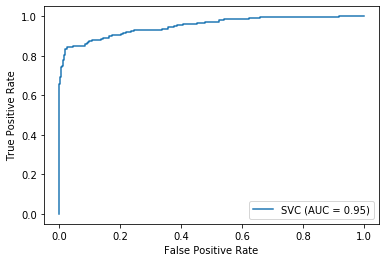

In [454]:
# ROC curve:
metrics.plot_roc_curve(clf, X_std, Y_inliers[:, 0]) 
plt.show()

### Subtask 2:
Predict whether sepsis will occur in the remaining stay: 0 means that no sepsis will occur, 1 otherwise. Similar to Subtask 1, you are asked to produce predictions in the interval [0, 1] for this task. The corresponding column containing the binary groundtruth in train_labels.csv is LABEL_Sepsis.

In [ ]:
# Why is this task different than the one before??

### Subtask 3:
Predict future mean values of key vital signs. The corresponding columns containing the real-valued groundtruth in train_labels.csv are LABEL_RRate, LABEL_ABPm, LABEL_SpO2, LABEL_Heartrate.

In [135]:
regcv = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
#regcv = linear_model.LassoLarsCV()
#regcv = linear_model.ElasticNetCV(cv=5)

for i in range(11, 15):
    regcv.fit(X_std, Y_inliers[:, i])
    alpha = regcv.alpha_
    
    reg = linear_model.Ridge(alpha=1)
    reg.fit(X_std, Y_inliers[:, i])
    print(i, ":", reg.score(X_std, Y_inliers[:, i]), "with alpha:", alpha)
    sol = reg.predict(X_test_std)
    
    sol = np.reshape(sol,[np.size(sol),1])
    solution = np.append(solution,sol,axis=1)

#regcv = linear_model.MultiTaskElasticNetCV(cv=5, fit_intercept=False)
#regcv = linear_model.MultiTaskLassoCV(cv=5, fit_intercept=False)

#regcv.fit(X_std, Y_inliers[:, 11:14])
#alpha = regcv.alpha_
#sol = regcv.predict(X_test_std)
#print(i, ":", regcv.score(X_std, Y_inliers[:, 11:14]), "with alpha:", alpha)

11 : 0.7214539815025193 with alpha: 1000.0


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 401 is different from 409)

In [101]:
solution = np.fliplr(solution)
X_test_ID = np.reshape(X_test_ID,[len(X_test_ID),1])
solution = np.append(solution,X_test_ID,axis=1)
solution = np.fliplr(solution)
print(solution.shape)
df = pd.DataFrame(solution, columns = ['pid','LABEL_BaseExcess','LABEL_Fibrinogen','LABEL_AST','LABEL_Alkalinephos','LABEL_Bilirubin_total','LABEL_Lactate','LABEL_TroponinI','LABEL_SaO2','LABEL_Bilirubin_direct','LABEL_EtCO2','LABEL_Sepsis','LABEL_RRate','LABEL_ABPm','LABEL_SpO2','LABEL_Heartrate'])
df.to_csv('prediction.zip', index=False, float_format='%.3f', compression='zip')
np.savetxt(output_file, df, fmt='%.10f')
print(df)

(12664, 16)
           pid  LABEL_BaseExcess  LABEL_Fibrinogen  LABEL_AST  \
0          0.0          0.807325          0.697541   0.723542   
1      10001.0          0.285325          0.267675   0.571397   
2      10003.0          0.520744          0.260591   0.375105   
3      10004.0          0.275314          0.318202   0.688347   
4      10005.0          0.266996          0.277428   0.274062   
...        ...               ...               ...        ...   
12659   9989.0          0.418193          0.432715   0.665431   
12660   9991.0          0.500146          0.536787   0.264566   
12661   9992.0          0.693806          0.287439   0.311083   
12662   9994.0          0.723981          0.697531   0.719083   
12663   9997.0          0.558646          0.298630   0.260056   

       LABEL_Alkalinephos  LABEL_Bilirubin_total  LABEL_Lactate  \
0                0.723379               0.723484       0.665821   
1                0.574520               0.590072       0.282233   
2     